# Getting Velocity From Linear Acceleration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import linregress
from scipy.integrate import simps
from scipy.integrate import trapz
from scipy.signal import resample
from statsmodels.nonparametric.smoothers_lowess import lowess
from find_cutoff import *
import seaborn

seaborn.set()

In [2]:
def setup_data(filename):
    """
    Sets up a dataframe with the data in the csv file called filename
    We make the following assumptions about the structure of the data:
    - There will be columns containing 'x', 'y', 'z', and 'time', for what you'd expect
    - The 'time' column is a time delta, i.e. some offset from 0
    """
    data = pd.read_csv(filename)

    # get data to look how everything else expects it
    xcol = data.filter(regex=r'(?i)x').columns[0]
    ycol = data.filter(regex=r'(?i)y').columns[0]
    zcol = data.filter(regex=r'(?i)z').columns[0]
    timecol = data.filter(regex=r'(?i)time').columns[0]
    data = data.rename(columns={xcol: 'x', ycol: 'y', zcol:'z', timecol: 'time'})

    # expect time to be in time delta format
    data['time'] = pd.to_timedelta(data['time'], unit='s')

    #data.set_index('time')
    data.index = data['time']

    # calculate the pre-resampling magnitude
    data['total'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

    data = find_cutoff_time(data)

    return data


# ~ 1.35m/s
filename = 'android_datasets/100walkpocketeast-lac.csv'
# ~ 1.54 m/s
#filename = 'android_datasets/100pocket-lac1.csv'
# ~ 1.59 m/s
#filename = 'android_datasets/100pocket-lac2.csv'
# ~ 1.69 m/s
#filename = 'android_datasets/100pocket-lac3.csv'
# ~ 1.234 m/s
#filename = 'android_datasets/100pocket-lac4.csv'

data = setup_data(filename)

/home/kasra/318/318-project/find_cutoff.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfl['dif'] = (dfl['filtered'] - middle).abs()
/home/kasra/318/318-project/find_cutoff.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfr['dif'] = (dfr['filtered'] - middle).abs()


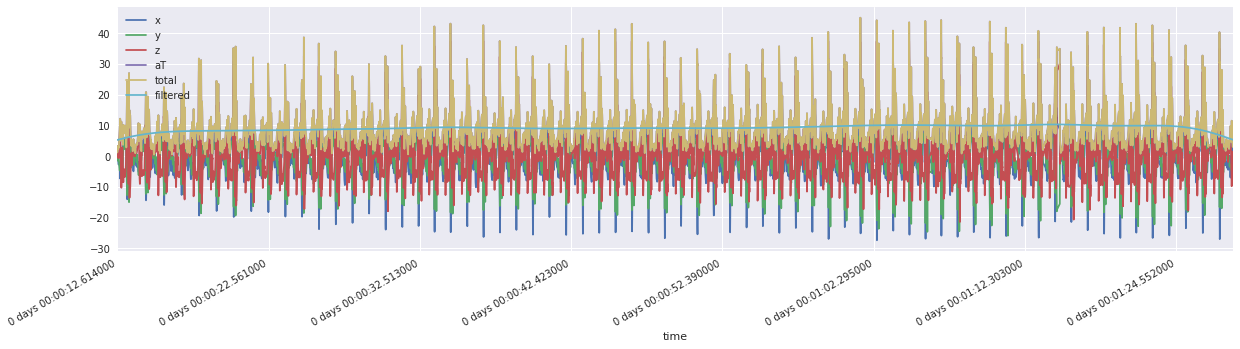

In [3]:
data.plot(figsize=(20, 5))
plt.show()

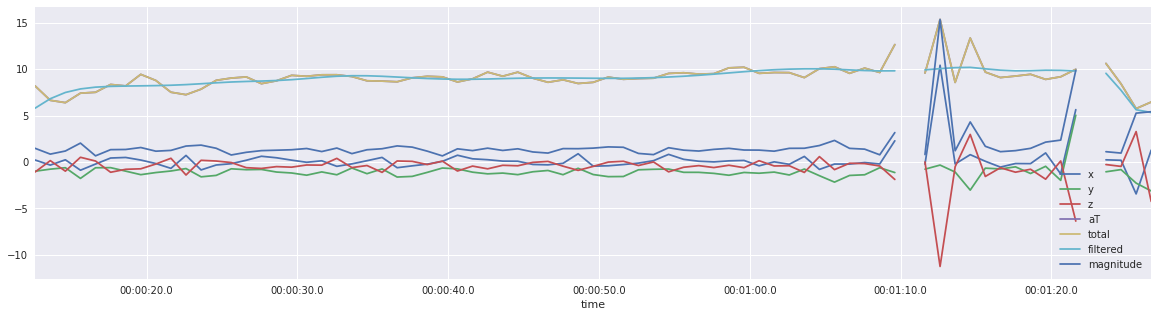

In [4]:
resampled = data.drop_duplicates().resample("1S").mean()
resampled['magnitude'] = np.sqrt(resampled['x']**2 + resampled['y']**2 + resampled['z']**2)
resampled.plot(figsize=(20, 5))
plt.show()

# Speed Approximations

Output units are m/s

In [5]:
ground_truth = 100 / resampled.shape[0]
ground_truth

1.3333333333333333

## Baseline (unfiltered)

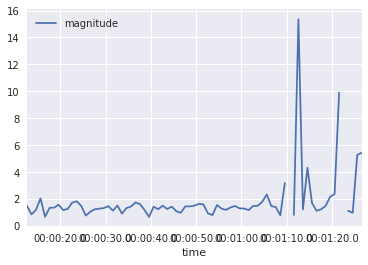

1.7895783810364052

In [6]:
from math import sqrt

def do_filter(series):
    b, a = signal.butter(5, .7, btype='low', analog=False)
    buttered = signal.filtfilt(b, a, series)
    return buttered

resampled['magnitude'].plot()
plt.legend()
plt.show()
simps(resampled['magnitude'].dropna())/resampled.shape[0]

## Lowess Smoothing

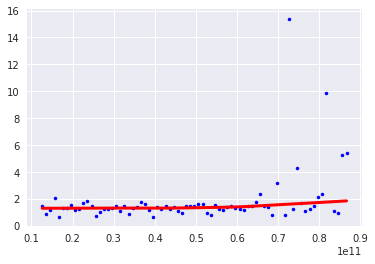

102.66632848230284

In [9]:
filtered = lowess(resampled['magnitude'].dropna().values, resampled['magnitude'].dropna().index)

plt.plot(resampled['magnitude'].dropna().index, resampled['magnitude'].dropna().values, 'b.')
plt.plot(resampled['magnitude'].dropna().index, filtered[:,1], 'r-', linewidth=3)
plt.show()
simps(filtered[:,1])#/resampled.shape[0]

## Butterworth Filter

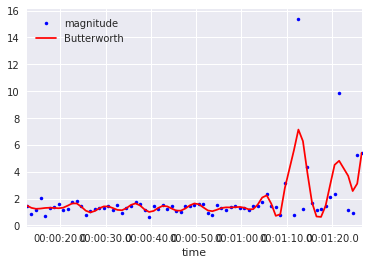

1.7247622081859697

In [8]:
b, a = signal.butter(5, .4, btype='low', analog=False)
buttered = signal.filtfilt(b, a, resampled['magnitude'].dropna())

resampled['magnitude'].plot(style='b.')
plt.plot(resampled['magnitude'].dropna().index, buttered, 'r-', label="Butterworth")
plt.legend()
plt.show()

simps(buttered)/resampled.shape[0]